In [ ]:
import pandas as pd
import requests
from matplotlib import pyplot as plt

# Effettua la richiesta GET all'API TfL
url = "https://api.tfl.gov.uk/AccidentStats/2019"  # Cambia l'anno a seconda dei dati che vuoi
response = requests.get(url)

# Carica la risposta in formato JSON
data = response.json()

# Converte il JSON in un DataFrame di pandas
df = pd.json_normalize(data)
df_init = df.copy()

# Salva il DataFrame in formato CSV
df.to_csv('dataframes/incidenti_tfl_2019.csv', index=False)

In [39]:
df.head()

,$type,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345906,51.511963,-0.028211,On Commercial Road Near The Junction With Burd...,2019-01-03T01:20:00Z,Slight,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345907,51.371636,-0.117621,On Purley Way 20 metres north of The Junction ...,2019-01-02T22:45:00Z,Slight,Croydon,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345908,51.514951,-0.072747,On Whitechapel High Street Near The Junction W...,2019-01-02T18:45:00Z,Slight,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345909,51.519173,-0.262356,On western Avenue 10 metres south of The Junct...,2019-01-03T08:41:00Z,Slight,Ealing,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345910,51.565743,-0.136308,On Macdonald Road 30 metres south of The Junct...,2019-01-03T08:37:00Z,Slight,Islington,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


In [40]:
df.describe()

,id,lat,lon
count,50626.000000,50626.000000,50626.000000
mean,544054.000000,51.509198,-0.118897
std,185715.647807,0.067383,0.141133
min,345828.000000,51.295233,-0.509795
25%,358484.250000,51.468225,-0.200805
50%,544054.000000,51.514006,-0.114336
75%,729623.750000,51.553555,-0.035484
max,742280.000000,51.691126,0.307909


Encode Severity to 0-1-2

In [41]:
df.drop(columns=['$type'], inplace=True)

# converting 'severity' in cardinal indicator
df['severity'] = df['severity'].map({'Slight': 0, 'Serious': 1, 'Fatal': 2})

Encode Borough values to one hot encoding

In [42]:
borough_encoded = pd.get_dummies(df['borough'], prefix='borough', dtype=int)
df = pd.concat([df, borough_encoded], axis=1)
df.drop('borough', axis=1, inplace=True)

Drop Location Column (Unused)

In [43]:
df.drop('location', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])

<Axes: ylabel='Frequency'>

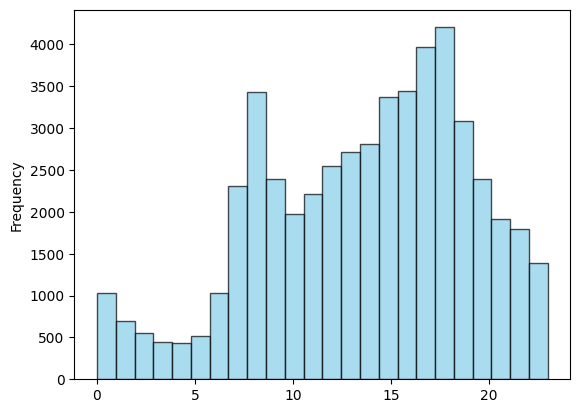

In [44]:
df['date'].dt.hour.plot.hist(bins=24, color='skyblue', edgecolor='black', alpha=0.7)

Encode Vehicles by Category

In [45]:
df_vehicles = df_init.copy()

if df_vehicles['vehicles'].isnull().any():
    print("Warning: Missing or invalid data detected in 'vehicles'. Dropping null values.")
    df_vehicles = df_vehicles.dropna(subset=['vehicles'])

df_vehicles = df_vehicles.explode('vehicles')

df_vehicles.drop(columns=['lat', 'lon', 'date', 'location', 'severity', 'borough', 'casualties'], inplace=True)

df_vehicles_normalized = pd.json_normalize(df_vehicles['vehicles'].values)

if '$type' in df_vehicles_normalized.columns:
    df_vehicles_normalized.drop(columns=['$type'], inplace=True)

df_vehicles = df_vehicles.reset_index(drop=True).join(df_vehicles_normalized)

df_vehicles.drop(columns=['vehicles', '$type'], inplace=True)

df_vehicles.head()


,id,type
0,345906,Car
1,345906,Car
2,345907,Car
3,345907,Car
4,345908,PedalCycle


In [46]:
categories = {
    "Motorcycle": [
        "Motorcycle_0_50cc", "Motorcycle_50_125cc", 
        "Motorcycle_125_500cc", "Motorcycle_500cc_Plus"
    ],
    "Car": [
        "Car", "Taxi", "Minibus", "LightGoodsVehicle"
    ],
    "Heavy_Vehicles": [
        "BusOrCoach", "HeavyGoodsVehicle", "MediumGoodsVehicle", 
        "AgriculturalVehicle"
    ],
    "Pedalcycle": ["PedalCycle"],
    "Other": ["OtherMotorVehicle", "RiddenHorse"]
}

# Map types to categories
category_map = {v: k for k, types in categories.items() for v in types}
df_vehicles['category'] = df_vehicles['type'].map(category_map)

# Count the number of vehicles in each category for each id
category_counts = df_vehicles.groupby(['id', 'category']).size().unstack(fill_value=0)
# Ensure all main categories are represented as columns
for category in categories.keys():
    if category not in category_counts.columns:
        category_counts[category] = 0

# Reset the index to prepare for further analysis
category_counts = category_counts.reset_index()
# category_counts.keys()
df_vehicles = category_counts
df_vehicles.head()
df_vehicles.to_csv('dataframes/vehicles_by_cat.csv', index=False)


Encode Casalties by Category

In [47]:
# Explode the casualties column
df_exploded = df_init.explode('casualties')
# Normalize the casualties field
casualties_df = pd.json_normalize(df_exploded['casualties'])
# Combine the normalized casualties back with the original data
df_exploded = df_exploded.drop(columns=['casualties']).reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df], axis=1)
# Extract ages
ages = casualties_df['age'].dropna().tolist()

# Display results
print("Extracted ages:", ages[:10])  # Display the first 10 ages
print("Lenght of ages: ", len(ages))

Extracted ages: [27.0, 42.0, 24.0, 48.0, 18.0, 33.0, 18.0, 29.0, 49.0, 59.0]
Lenght of ages:  57116


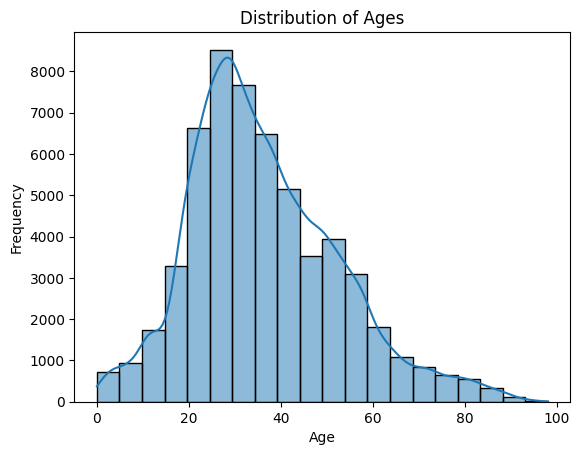

In [48]:
import seaborn as sns
sns.histplot(ages, bins=20, kde=True)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Ages")
plt.show()

In [49]:
age_ranges = {
    "0-17": 0,
    "18-25": 0,
    "26-40": 0,
    "41-65": 0,
    "65+": 0
}
for age in ages:
    if age <= 17:
        age_ranges["0-17"] += 1
    elif age <= 25:
        age_ranges["18-25"] += 1
    elif age <= 40:
        age_ranges["26-40"] += 1
    elif age <= 65:
        age_ranges["41-65"] += 1
    else:
        age_ranges["65+"] += 1

print(age_ranges)

{'0-17': 4730, '18-25': 10214, '26-40': 22162, '41-65': 16916, '65+': 3094}


In [50]:
bins, bin_edges = pd.qcut(ages, q=5, labels=["0-23", "24-30", "31-38", "39-50", "50+"], retbins=True)
print("Bin Edges:", bin_edges)
print("Bins:", bins)
print(bins.value_counts())

Bin Edges: [ 0. 23. 30. 38. 50. 98.]
Bins: ['24-30', '39-50', '24-30', '39-50', '0-23', ..., '50+', '0-23', '24-30', '24-30', '39-50']
Length: 57116
Categories (5, object): ['0-23' < '24-30' < '31-38' < '39-50' < '50+']
0-23     11764
24-30    11744
31-38    11230
39-50    11648
50+      10730
Name: count, dtype: int64


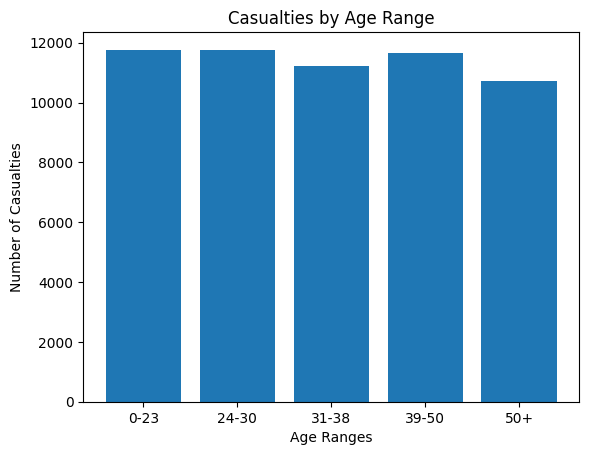

In [51]:
age_ranges = ["0-23", "24-30", "31-38", "39-50", "50+"]
counts = [11764, 11744, 11230, 11648, 10730]

plt.bar(age_ranges, counts)
plt.xlabel("Age Ranges")
plt.ylabel("Number of Casualties")
plt.title("Casualties by Age Range")
plt.show()

In [52]:
# Assume df is your original DataFrame
# Explode the casualties column to work with individual casualties
df_exploded = df_init.explode('casualties')

# Normalize the casualties field to extract age
casualties_df = pd.json_normalize(df_exploded['casualties'])
df_exploded = df_exploded.reset_index(drop=True)
df_combined = pd.concat([df_exploded, casualties_df[['age']]], axis=1)

# Define a function to count casualties in each range
def count_age_ranges(group):
    age_counts = {
        "casualty_age_0-23": sum(group['age'] <= 23),
        "casualty_age_24-30": sum((group['age'] > 23) & (group['age'] <= 30)),
        "casualty_age_31-38": sum((group['age'] > 30) & (group['age'] <= 38)),
        "casualty_age_39-50": sum((group['age'] > 38) & (group['age'] <= 50)),
        "casualty_age_50+": sum(group['age'] > 50)
    }
    return pd.Series(age_counts)

# Group by accident ID and apply the function
age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()
age_range_counts.head()
age_range_counts.to_csv('dataframes/age_range_counts_to_merge.csv', index=False)
# Merge the counts back to the original DataFrame
# df_with_age_ranges = df.merge(age_range_counts, on='id', how='left')


C:\Users\AaronSalazar\AppData\Local\Temp\ipykernel_21648\190801574.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  age_range_counts = df_combined.groupby('id').apply(count_age_ranges).reset_index()


In [53]:
df.drop(["casualties", "vehicles"],axis=1, inplace=True)
df_merged = df.merge(df_vehicles, on='id', how='left')
df_merged = df.merge(age_range_counts, on='id', how='left')
df_merged.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,2019-01-03 01:20:00+00:00,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,2019-01-02 22:45:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,2019-01-02 18:45:00+00:00,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,345909,51.519173,-0.262356,2019-01-03 08:41:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,2019-01-03 08:37:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [54]:
df_merged.to_csv('dataframes/final_df.csv', index=False)